In [1]:
%%time
import os
import cv2
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam, SGD
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
import time
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from coco_preprocessing import *
from expl_train_utils import *

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


CPU times: user 2.7 s, sys: 1.2 s, total: 3.9 s
Wall time: 2.63 s


### Load Dataset

In [2]:
dataDir=''
dataType='val2017'
annFile='annotations/instances_{}.json'.format(dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [4]:
num_cats = 10

In [5]:
# Get categories with largest number of images to use
numCatImgs = []
for i in range(90):
    numCatImgs.append((i, len(coco.getImgIds(catIds=i))))
numCatImgs.sort(key=lambda x: x[1])
usedCatImgs = numCatImgs[-num_cats:] # list of (catId, numImgs) tuples
minNumImgs = usedCatImgs[0][1] # number of images available for smallest used cat(egory)
used_ids = [tup[0] for tup in usedCatImgs] # list of catIds used

used_cats = coco.loadCats(coco.getCatIds(catIds=used_ids))
cat_names = [cat['name'] for cat in used_cats]
print('{} COCO categories used: \n{}\n'.format(len(used_cats), ' '.join(cat_names)))

10 COCO categories used: 
person car truck bench handbag bottle cup bowl chair dining table



In [6]:
print(used_ids)

[15, 8, 31, 51, 44, 47, 67, 3, 62, 1]


### Load All Images

In [9]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]

In [10]:
%%time
# preprocess --> bboxImgs, object_labels, configs, shapelyPolygons
data = [preprocess(coco, img_info, used_ids) for img_info in coco.loadImgs(imgIds)[:100]]
data = np.array(data)
np.random.shuffle(data)

CPU times: user 1.34 s, sys: 72 ms, total: 1.41 s
Wall time: 10.4 s


### Using Keras VGG16 Model

In [7]:
input_tensor = Input(shape=(96, 96, 3))
inet_model = vgg16.VGG16(input_tensor=input_tensor, weights=None, include_top=False)

In [8]:
num_samples = 100
batch_size = 10
num_classes = 10
num_batches = num_samples // batch_size
iteration = 0

base_model = inet_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['acc'])

In [11]:
x_train = data[:, 0] # Bbox images

temp = []
for bbox_imgs in x_train:
    for img in bbox_imgs:
        if len(img.shape) != 3:
            img = np.stack((img,) * 3, -1)
        alt_img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
        temp.append(alt_img)

x_train = np.array(temp)

In [12]:
y_train = data[:, 1]
y_train = np.array([label[0] for labels in y_train for label in labels])

temp = np.zeros((y_train.shape[0], num_cats))
for ft in used_ids:
    vec = np.zeros(num_cats)
    vec[used_ids.index(ft)] = 1
    temp[np.where(y_train == ft)] = vec

y_train = temp

In [13]:
configs = np.array([config for configs in data[:, 2] for config in configs])

In [14]:
shapely_polygons = np.array([polygon for polygons in data[:, 3] for polygon in polygons])

In [22]:
%%time
# Make sure model trains
model.fit(x_train, y_train,
          epochs=10,
          batch_size=128,
          shuffle=False,
          validation_split=0.1)

print("Evaluating ...")
model.evaluate(x_train, y_train, batch_size=128, verbose=0)

Train on 40344 samples, validate on 4483 samples
Epoch 1/10
40344/40344 [==============================] - 166s 4ms/step - loss: 1.8093 - acc: 0.4727 - val_loss: 2.0179 - val_acc: 0.4691
Epoch 2/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.7377 - acc: 0.4757 - val_loss: 1.9420 - val_acc: 0.4691
Epoch 3/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.7027 - acc: 0.4761 - val_loss: 1.9107 - val_acc: 0.4691
Epoch 4/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6776 - acc: 0.4776 - val_loss: 1.9092 - val_acc: 0.4691
Epoch 5/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6604 - acc: 0.4792 - val_loss: 1.9132 - val_acc: 0.4691
Epoch 6/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6474 - acc: 0.4807 - val_loss: 1.9004 - val_acc: 0.4689
Epoch 7/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6369 - acc: 0.4822 - val_loss: 1.9132 - v

[1.8887753149484847, 0.4745800521933695]

In [ ]:
%%time
# Using Epsilon-Greedy
start_iter = 0
num_training_samples = 100
num_iterations = 1
samples_per_iter = num_training_samples // num_iterations
explainer_batch_size = 128
batch_size = 128
sp = SubPlotter(num_iterations, use_bandits=True)

for iteration in range(start_iter, start_iter + num_iterations):
    start = iteration * samples_per_iter
    end = (iteration + 1) * samples_per_iter
    
    x_train_batch = x_train[start:end]
    y_train_batch = y_train[start:end]
    configs_batch = configs[start:end]
    shapely_polygons_batch = configs[start:end]
    
    model.fit(x_train_batch, y_train_batch,
              epochs=1,
              batch_size=batch_size,
              shuffle=False,
              validation_data=(x_train[-100:], y_train[-100:]))
    
    info = sp.analyzeIoU(x_train_batch, y_train_batch, shapely_polygons_batch, limit=20)
    sp.plot_seg_extremes(info, configs_batch)

    print("loss, accuracy = {}\n".format(model.evaluate(x_train, y_train, batch_size=128, verbose=0)))

sp.end()

Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 12s 123ms/step - loss: 2.4522 - acc: 0.0100 - val_loss: 1.7245 - val_acc: 0.5500


### Load Single Image (either run this or the `Load All Images` section)

In [7]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])
img = coco.loadImgs(70229)[0]

In [8]:
print(img)

{'license': 1, 'file_name': '000000070229.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000070229.jpg', 'height': 640, 'width': 481, 'date_captured': '2013-11-24 02:18:11', 'flickr_url': 'http://farm8.staticflickr.com/7174/6397141265_aa0f0d8a4e_z.jpg', 'id': 70229}


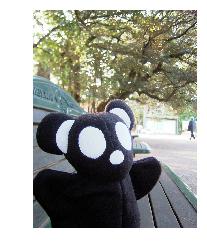

In [9]:
I = imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

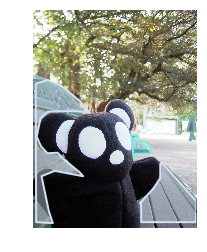

In [10]:
# load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=used_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [11]:
bboxImgs, object_labels, configs, shapelyPolygons = preprocess(coco, img, used_ids)

In [12]:
print(len(configs))

3


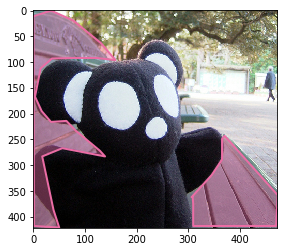

In [13]:
show_gt_mask(*configs[1])

p = Pgon(pairwise_group(alt_segs[0][0]))  
p.contains(Point(20, 60))